# Basic setup

In [1]:
import os
import glob
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors, cm
import seaborn as sns
from nltools.data import Brain_Data, Adjacency
from nltools.mask import expand_mask, roi_to_brain
from nltools.stats import isc, isc_group, isfc, isps, fdr, threshold, phase_randomize, circle_shift, matrix_permutation
from nltools.plotting import plot_brain
from nilearn.plotting import plot_glass_brain, view_img_on_surf, view_img, plot_stat_map, plot_roi, find_parcellation_cut_coords, plot_connectome
from nilearn import image as nimg
from sklearn.metrics import pairwise_distances
from scipy.stats import ttest_1samp, rankdata, stats, spearmanr, kendalltau, pearsonr
import nibabel as nib
from rpy2.robjects.packages import importr
from rpy2.robjects.vectors import FloatVector
from scipy.spatial.distance import pdist
from scipy.spatial import distance
import seaborn as sns
import warnings

## Load a brain mask based on the AAL atlas version 3 -- <b>166 ROIs</b>
#### Reference for the atlas: https://www.sciencedirect.com/science/article/pii/S1053811919307803

In [2]:
def get_subject_roi(data, roi):
    sub_rois = {}
    for sub in data:
        sub_rois[sub] = data[sub].iloc[:, roi]
    return pd.DataFrame(sub_rois)

In [3]:
# Download a brain mask for the parcellation: https://neurovault.org/images/395092/
mask = Brain_Data('D:/fmri_sugar/other/AAL3v1.nii')
mask_x = expand_mask(mask)

In [4]:
# Load also the labels of the ROIs
labels = pd.read_csv('D:/fmri_sugar/other/AAL3v1_labels.csv', header = None)
labels = labels.dropna()
labels = labels[0]

 <center><h1> Technical validation of the preprocessed data </h1></center>

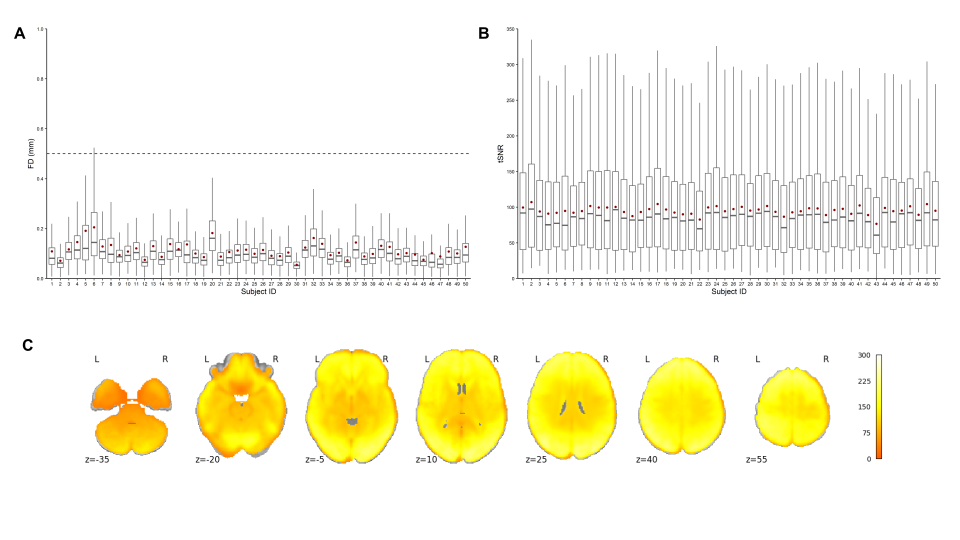

In [5]:
from IPython.display import SVG, display
display(SVG('D:/fmri_sugar/results/important/Supplementary_Figure_1.svg'))

# <center><b> Intersubject correlation (ISC) analysis </b></center>

In [6]:
data_dir = 'D:/fmri_sugar/data_ISC'
sub_list = [os.path.basename(x).split('_')[0] for x in glob.glob(os.path.join(data_dir, 'sub*.csv'))] ### Correct the split [1] to [0]
sub_list.sort()

In [7]:
sub_timeseries = {}
for sub in sub_list:
    avg_bold = pd.read_csv(os.path.join(data_dir, f'{sub}_AAL.csv'))
    avg_bold.reset_index(inplace=True, drop=True)
    sub_timeseries[sub] = avg_bold

In [8]:
# ISC analysis
isc_r, isc_p = {}, {}
for roi in range(len(labels)):
    stats = isc(get_subject_roi(sub_timeseries, roi), n_samples=10000, metric='mean', method='bootstrap', tail=1, random_state=1)
    isc_r[roi], isc_p[roi] = stats['isc'], stats['p']

isc_r_brain, isc_p_brain = roi_to_brain(pd.Series(isc_r), mask_x), roi_to_brain(pd.Series(isc_p), mask_x)

In [9]:
# Correct for multiple comparisons with BH method
stat = importr('stats')
p_adjust = pd.Series(stat.p_adjust(FloatVector(pd.Series(isc_p.values())), method = 'BH'))
isc_p_brain_fdr = roi_to_brain(p_adjust, mask_x)

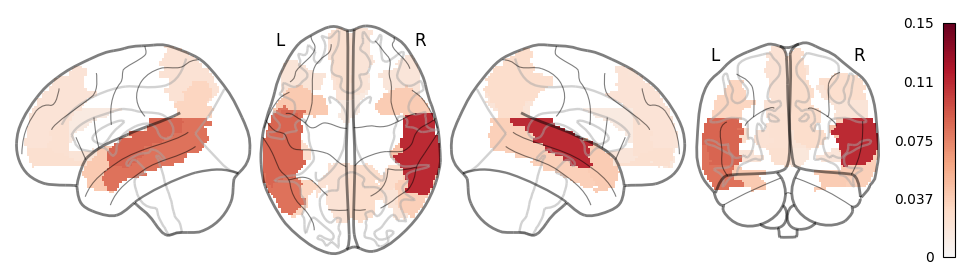

In [10]:
disp = plot_glass_brain(threshold(isc_r_brain, isc_p_brain_fdr, 0.05).to_nifti(), vmax=0.15, vmin=np.min(pd.Series(isc_r.values())), symmetric_cbar=False, colorbar=True, cmap='RdBu_r', display_mode="lzry", alpha=0.5, plot_abs=False)
disp.savefig('D:/fmri_sugar/results/important/ISC', dpi=300)

In [11]:
# Print the ROIs with significant ISC
isc_results = {'ROI': [labels[x] for x in range(len(labels)) if p_adjust[x] < 0.05],
     'ISC': [isc_r[x] for x in range(len(labels)) if p_adjust[x] < 0.05],
     'BH-correctd p-value': [p_adjust[x] for x in range(len(labels)) if p_adjust[x] < 0.05]}

pd.DataFrame(data=isc_results).sort_values(by=['ROI'], ascending=False)

,ROI,ISC,BH-correctd p-value
14,Temporal_Sup_R,0.111413,0.002766
13,Temporal_Sup_L,0.087407,0.002766
16,Temporal_Pole_Sup_R,0.037841,0.002766
15,Temporal_Pole_Sup_L,0.039829,0.002766
18,Temporal_Mid_R,0.036268,0.007545
17,Temporal_Mid_L,0.081851,0.002766
10,Precuneus_R,0.026368,0.019219
9,Precuneus_L,0.021186,0.015622
6,Parietal_Inf_R,0.025650,0.008938
12,Heschl_R,0.042296,0.005533


# <center><b> Can the ISC predict the efficacy of expert persuasion? </b></center>

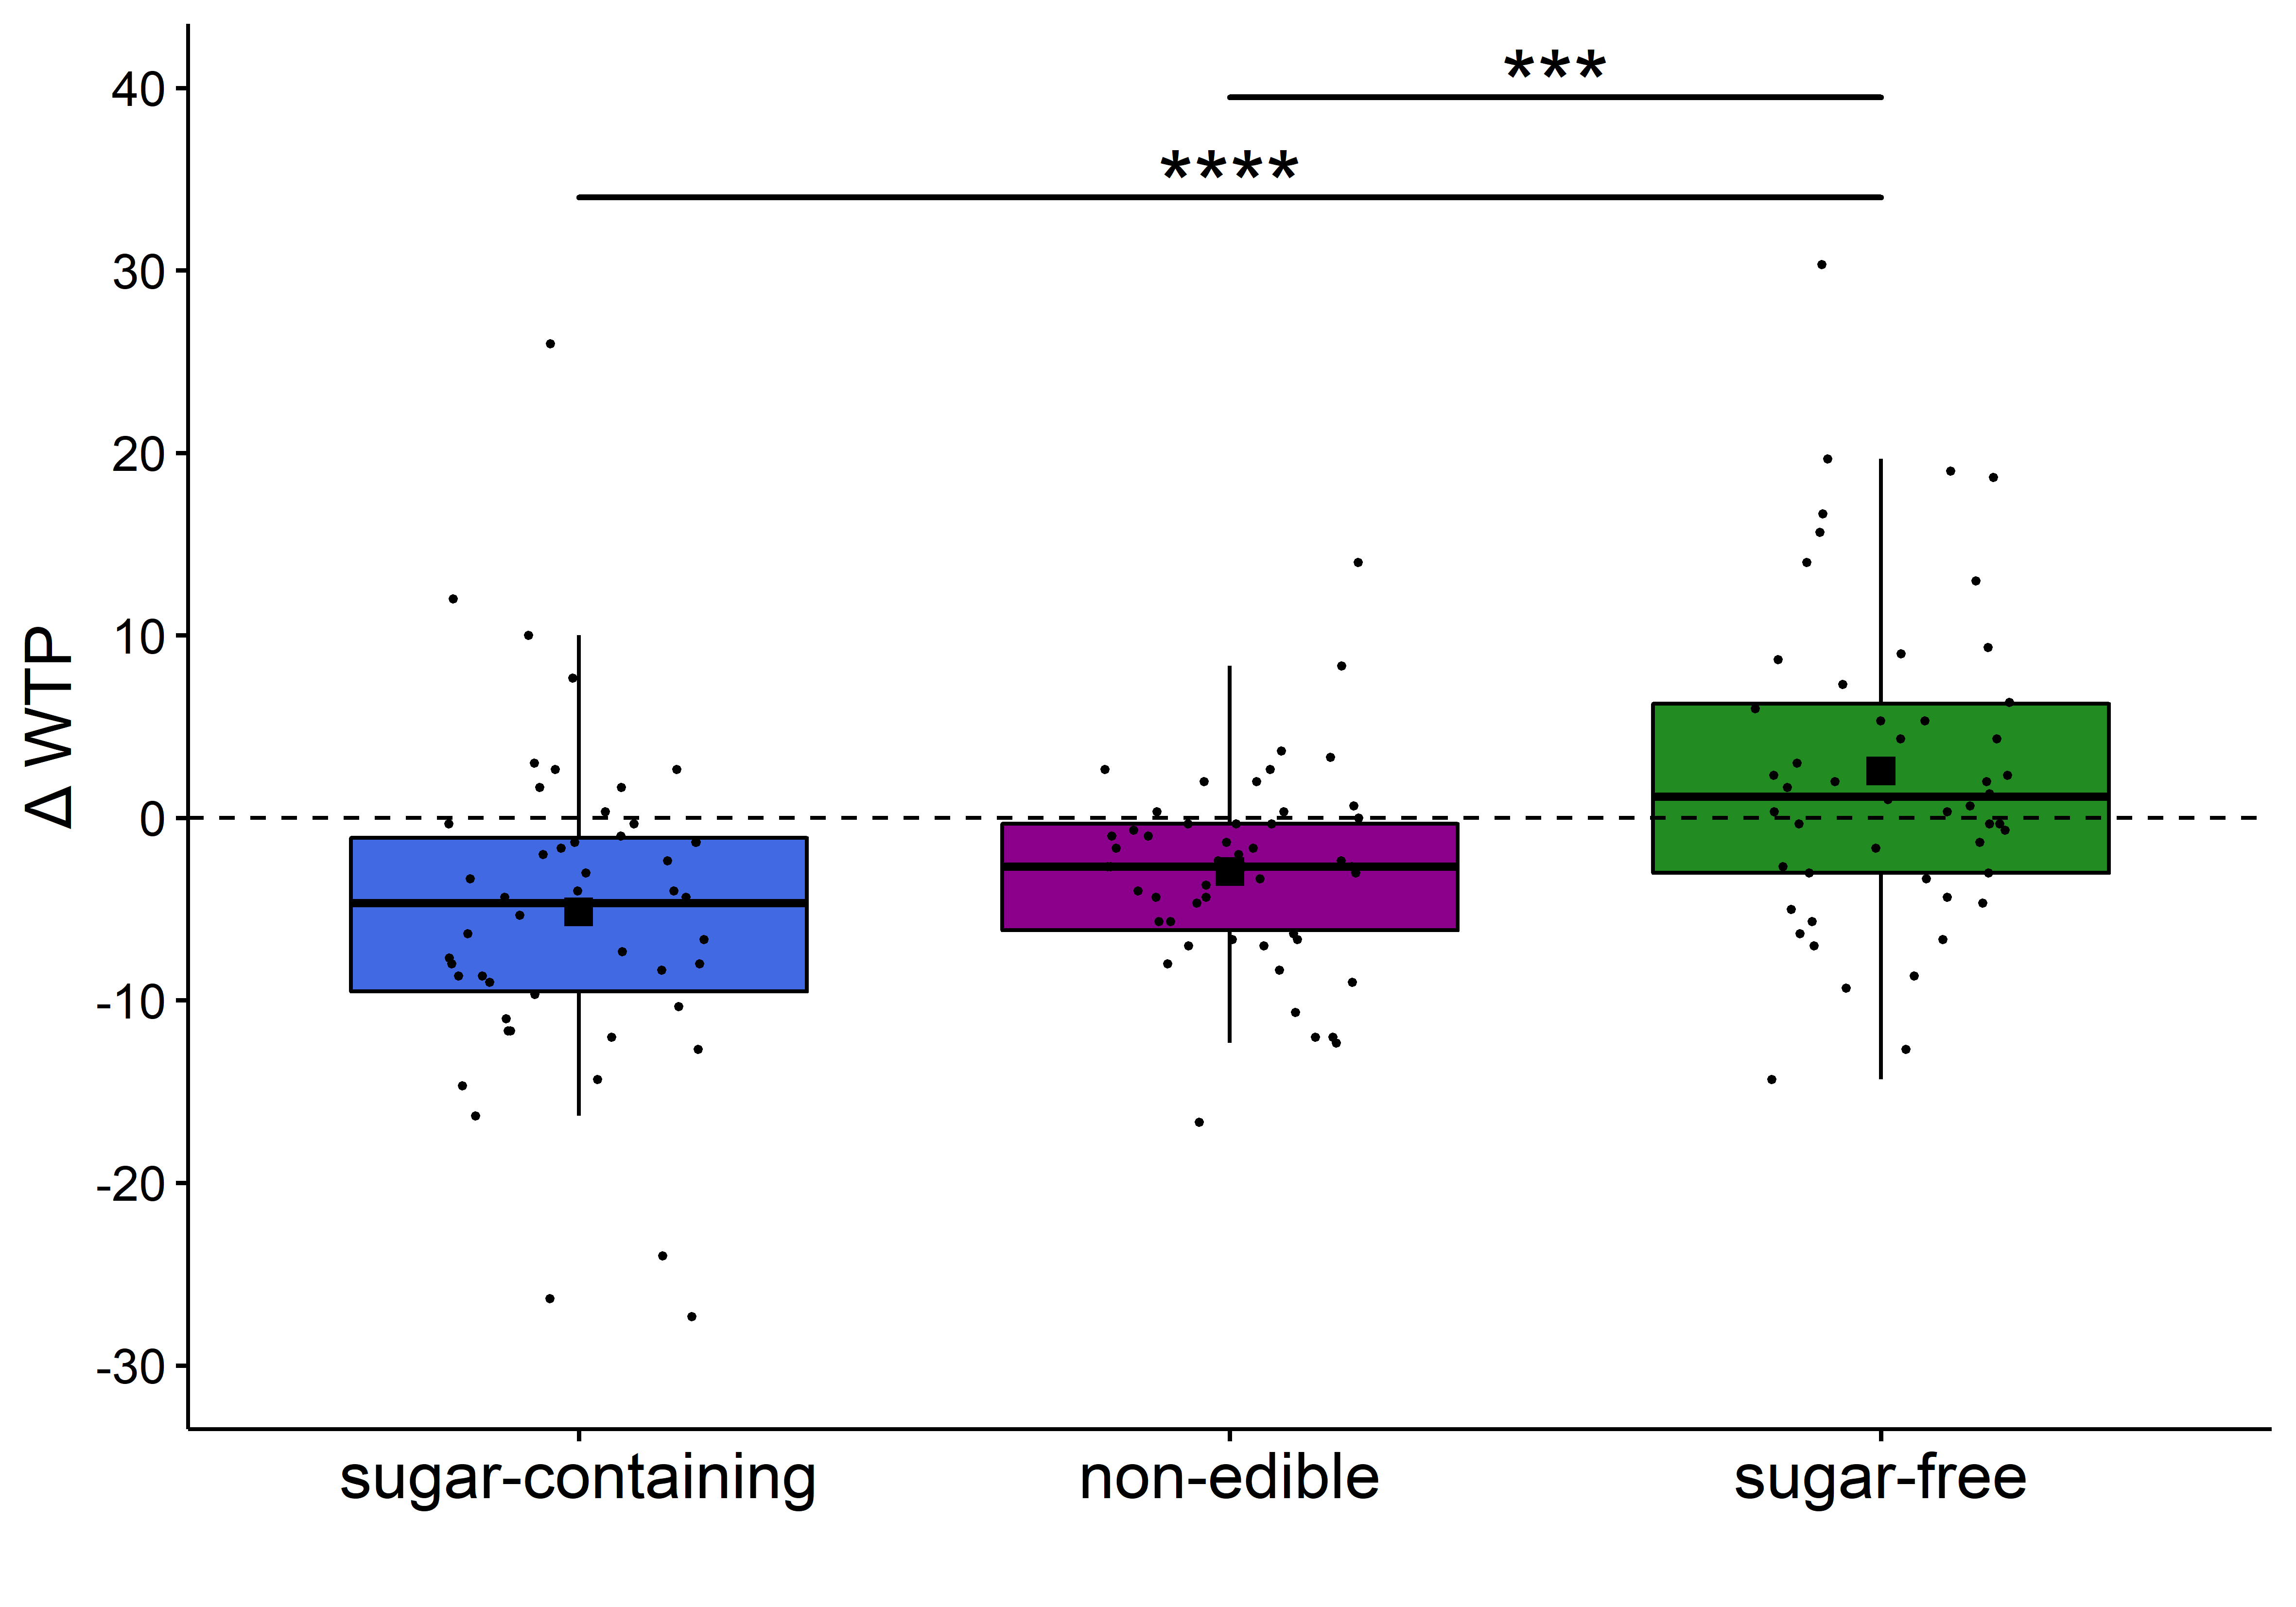

In [12]:
from IPython import display
display.Image('D:/fmri_sugar/results/important/Delta_WTP.png', width=1200)

<br>
<br>
<br>
<hr>
<br>
<br>
<br>

#    <center><b> Contrast between subgroups (influenced vs. not influenced,  <span style="color: red"> median split </span>) </b></center>

In [8]:
# First, we load the behavioral scores
deltas = pd.read_csv('D:/fmri_sugar/results/deltas.csv', index_col=False)

delta_sugar = - deltas['sugar_containing'] # Be careful! This one we multiply by -1, because low values mean high influence
delta_sugarfree = deltas['sugar_free']
#delta_combined = deltas['combined_score']

In [9]:
np.quantile(delta_sugar, 0.5)

3.0

In [15]:
# ISC group comparison
isc_r_sugar, isc_p_sugar, isc_r_sugarfree, isc_p_sugarfree, isc_r_combined, isc_p_combined = {}, {}, {}, {}, {}, {}

for roi in range(len(labels)):
    
    # In terms of sugar-containing scores
    both_groups = get_subject_roi(sub_timeseries, roi)
    influenced = both_groups.iloc[:,[i for i in range(len(delta_sugar)) if delta_sugar[i] > np.quantile(delta_sugar, 0.5)]] # change this to another percentage for extremes (e.g., 20%)
    not_influenced = both_groups.iloc[:,[i for i in range(len(delta_sugar)) if delta_sugar[i] <= np.quantile(delta_sugar, 0.5)]] # change this to another percentage for extremes (e.g., 20%)
    stats = isc_group(influenced, not_influenced, n_samples=10000, metric='mean', method='permute', random_state=1)
    isc_r_sugar[roi], isc_p_sugar[roi] = stats['isc_group_difference'], stats['p']
    

    # In terms of sugar-free scores
    both_groups = get_subject_roi(sub_timeseries, roi)
    influenced = both_groups.iloc[:,[i for i in range(len(delta_sugarfree)) if delta_sugarfree[i] > np.quantile(delta_sugarfree, 0.5)]] # change this to another percentage for extremes (e.g., 20%)
    not_influenced = both_groups.iloc[:,[i for i in range(len(delta_sugar)) if delta_sugarfree[i] <= np.quantile(delta_sugarfree, 0.5)]] # change this to another percentage for extremes (e.g., 20%)
    stats = isc_group(influenced, not_influenced, n_samples=10000, metric='mean', method='permute', random_state=1)
    isc_r_sugarfree[roi], isc_p_sugarfree[roi] = stats['isc_group_difference'], stats['p']

C:\Programs\Anaconda3\envs\taiwan\lib\site-packages\nilearn\plotting\displays\_slicers.py:382: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


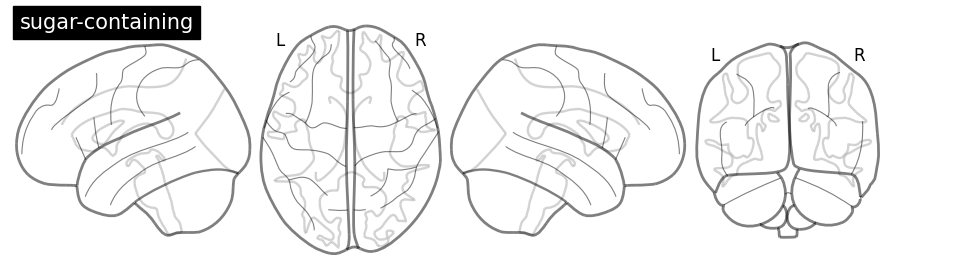

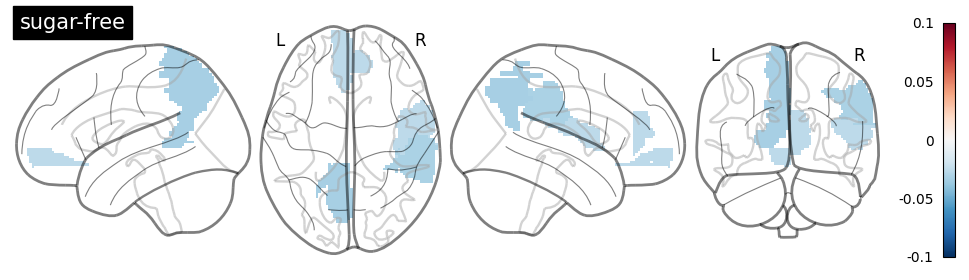

In [16]:
# Put everything together and visualize
isc_r_sugar_brain, isc_p_sugar_brain, isc_p_sugar_brain_fdr = roi_to_brain(pd.Series(isc_r_sugar), mask_x), roi_to_brain(pd.Series(isc_p_sugar), mask_x), roi_to_brain(pd.Series(stat.p_adjust(FloatVector(pd.Series(isc_p_sugar.values())), method = 'BH')), mask_x)
isc_r_sugarfree_brain, isc_p_sugarfree_brain, isc_p_sugarfree_brain_fdr = roi_to_brain(pd.Series(isc_r_sugarfree), mask_x), roi_to_brain(pd.Series(isc_p_sugarfree), mask_x), roi_to_brain(pd.Series(stat.p_adjust(FloatVector(pd.Series(isc_p_sugarfree.values())), method = 'BH')), mask_x)

plot_glass_brain(threshold(isc_r_sugar_brain, isc_p_sugar_brain_fdr, 0.05).to_nifti(), symmetric_cbar=True, colorbar=True, cmap='RdBu_r', display_mode="lzry", alpha=0.5, title="sugar-containing", vmax=0.1)
plot_glass_brain(threshold(isc_r_sugarfree_brain, isc_p_sugarfree_brain_fdr, 0.05).to_nifti(), symmetric_cbar=True, colorbar=True, cmap='RdBu_r', display_mode="lzry", alpha=0.5, title="sugar-free", vmax=0.1)

Plotting unthresholded image


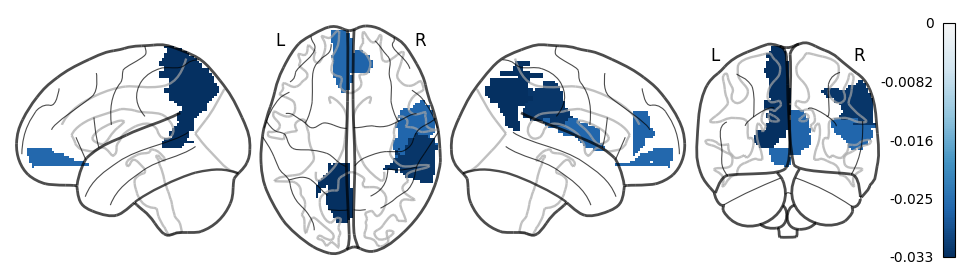

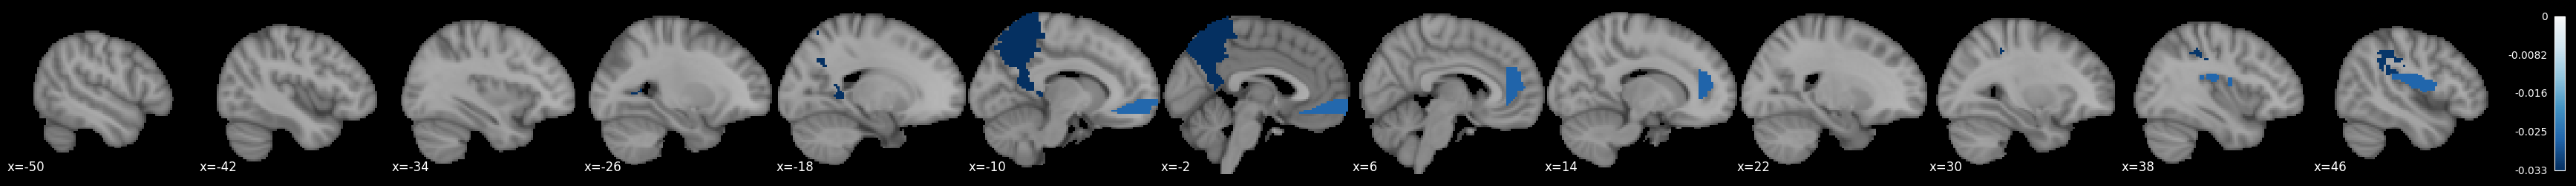

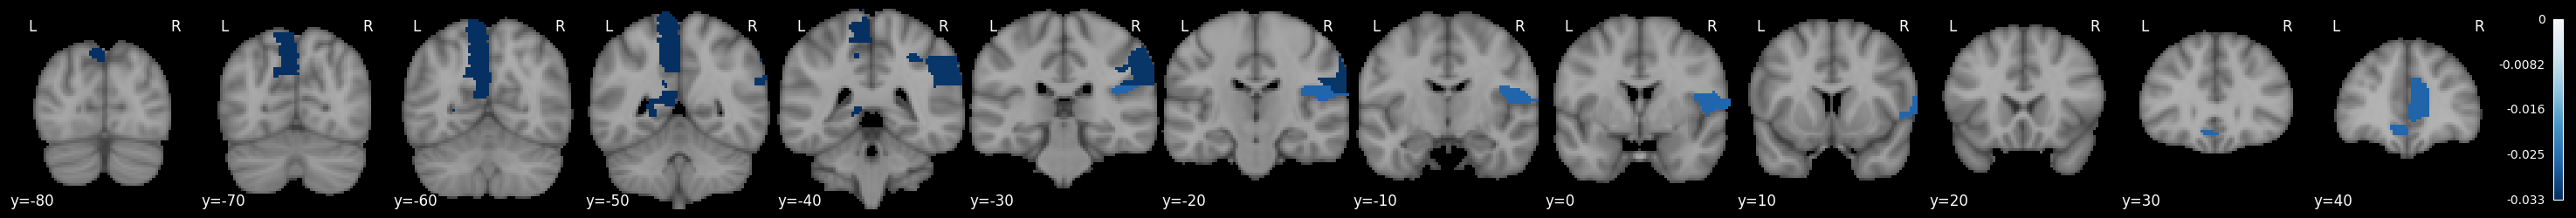

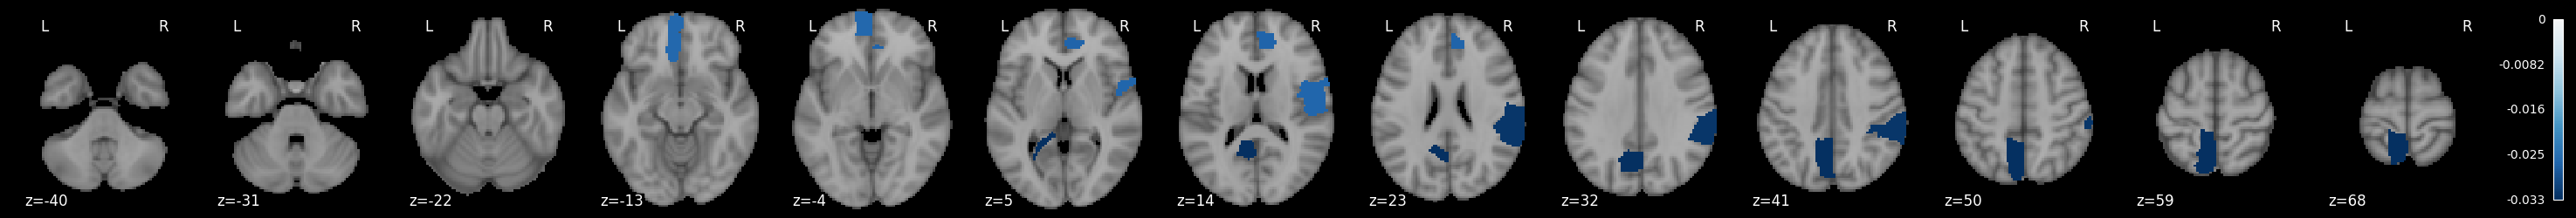

In [20]:
plot_brain(threshold(isc_r_sugarfree_brain, isc_p_sugarfree_brain_fdr, 0.05))

In [19]:
# Print the ROIs with significant ISC (only sugar-free condition)
isc_results = {'ROI': [labels[x] for x in range(len(labels)) if pd.Series(stat.p_adjust(FloatVector(pd.Series(isc_p_sugarfree.values())), method = 'BH'))[x] < 0.05],
     'ISC': [isc_r_sugarfree[x] for x in range(len(labels)) if pd.Series(stat.p_adjust(FloatVector(pd.Series(isc_p_sugarfree.values())), method = 'BH'))[x] < 0.05],
     'BH-correctd p-value': [pd.Series(stat.p_adjust(FloatVector(pd.Series(isc_p_sugarfree.values())), method = 'BH'))[x] for x in range(len(labels)) if pd.Series(stat.p_adjust(FloatVector(pd.Series(isc_p_sugarfree.values())), method = 'BH'))[x] < 0.05]}

pd.DataFrame(data=isc_results).sort_values(by=['ROI'], ascending=False)

,ROI,ISC,BH-correctd p-value
2,SupraMarginal_R,-0.032030,0.00332
0,Rolandic_Oper_R,-0.026151,0.00332
3,Precuneus_L,-0.032891,0.00332
1,Frontal_Med_Orb_L,-0.025827,0.00332
4,ACC_pre_R,-0.026427,0.00332


In [20]:
backup = isc_r_sugarfree_brain.data
isc_r_sugarfree_brain.data = -isc_r_sugarfree_brain.data

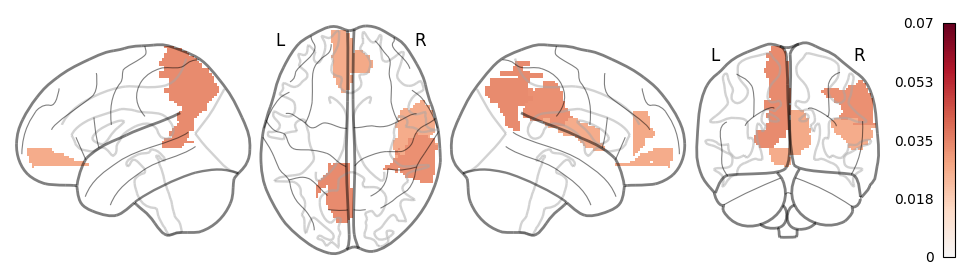

In [24]:
disp = plot_glass_brain(threshold(isc_r_sugarfree_brain, isc_p_sugarfree_brain_fdr, 0.05).to_nifti(), symmetric_cbar=False, plot_abs=False, colorbar=True, cmap='RdBu_r', display_mode="lzry", alpha=0.5, vmax=0.07)
disp.savefig('D:/fmri_sugar/results/important/ISC_contrast_sugarfree.png', dpi=300)

# ISFC of the above ROIs

## First, we extract the timeseries per ROI per group

In [10]:
# Load also the labels of the ROIs
labels = pd.read_csv('D:/fmri_sugar/other/AAL3v1_labels.csv', header = None)
labels = labels.dropna()
labels = labels[0]

In [11]:
rois = [str(i) for i in range(len(labels)) if labels[i] in ['ACC_pre_R','Precuneus_L','Frontal_Med_Orb_L','Rolandic_Oper_R','SupraMarginal_R']]
ids = [int(x) for x in rois]
[labels[int(x)] for x in rois]

['Rolandic_Oper_R',
 'Frontal_Med_Orb_L',
 'SupraMarginal_R',
 'Precuneus_L',
 'ACC_pre_R']

In [12]:
influenced = [sub_list[i] for i in range(len(sub_list)) if delta_sugarfree[i] > np.quantile(delta_sugarfree, 0.5)]
not_influenced = [sub_list[i] for i in range(len(sub_list)) if delta_sugarfree[i] <= np.quantile(delta_sugarfree, 0.5)]

In [13]:
influenced_timeseries = {}
for sub in influenced:
    avg_bold = pd.read_csv(os.path.join(data_dir, f'{sub}_AAL.csv'))
    avg_bold.reset_index(inplace=True, drop=True)
    avg_bold = avg_bold[rois] # select only the 5 rois from isc contrast
    influenced_timeseries[sub] = avg_bold.to_numpy()
influenced_timeseries = list(influenced_timeseries.values())

In [14]:
not_influenced_timeseries = {}
for sub in not_influenced:
    avg_bold = pd.read_csv(os.path.join(data_dir, f'{sub}_AAL.csv'))
    avg_bold.reset_index(inplace=True, drop=True)
    avg_bold = avg_bold[rois] # select only the 5 rois from isc contrast
    not_influenced_timeseries[sub] = avg_bold.to_numpy()
not_influenced_timeseries = list(not_influenced_timeseries.values())

In [15]:
isfc_influenced = isfc(influenced_timeseries)
isfc_not_influenced = isfc(not_influenced_timeseries)

avg_isfc_influenced = np.array(isfc_influenced).mean(axis=0)
avg_isfc_not_influenced = np.array(isfc_not_influenced).mean(axis=0)

In [16]:
from scipy import stats

tvalues = np.array([[0.0 for col in range(len(rois))] for rows in range(len(rois))])
pvalues = np.array([[0.0 for col in range(len(rois))] for rows in range(len(rois))])
for i in range(len(rois)):
    for j in range(len(rois)):
        group1 = [isfc_influenced[x][i,j] for x in range(len(isfc_influenced))]
        group2 = [isfc_not_influenced[x][i,j] for x in range(len(isfc_not_influenced))]
        tvalues[i,j], pvalues[i,j] = stats.ttest_ind(group2, group1)

In [17]:
np.set_printoptions(suppress = True)
tvalues

array([[3.4717381 , 1.56629018, 3.33267484, 2.12316488, 1.2616064 ],
       [1.72511488, 3.25639978, 1.29540077, 1.50161254, 2.58856127],
       [2.92642661, 1.24641091, 5.05316908, 4.93667302, 3.39275189],
       [1.24016703, 0.95789731, 3.96121016, 5.12480513, 2.6927486 ],
       [1.82933828, 2.71456159, 3.39114483, 3.77190118, 4.41229327]])

In [18]:
# correct for multiple comparisons
stat = importr('stats')
pvalues_adjusted = pd.Series(stat.p_adjust(FloatVector(pd.Series(pvalues.flatten()))))
pvalues_adjusted.to_numpy().reshape(5,5)

array([[0.02098245, 0.86695215, 0.02660063, 0.38922835, 1.        ],
       [0.72752657, 0.03110108, 1.        , 0.86695215, 0.13988398],
       [0.07315734, 1.        , 0.00016139, 0.00022997, 0.02510298],
       [1.        , 1.        , 0.00517478, 0.00013158, 0.11950596],
       [0.662078  , 0.11950596, 0.02510298, 0.00889518, 0.00126889]])

In [19]:
cell_numbers = pvalues_adjusted.to_numpy().reshape(5,5)
cell_labels = [[' ' for x in range(cell_numbers.shape[0])] for y in range(cell_numbers.shape[1])] 
for i in range(cell_numbers.shape[0]):
    for j in range(cell_numbers.shape[1]):
        if cell_numbers[i,j] < 0.05 or cell_numbers[j,i] < 0.05:
            cell_labels[i][j] = '*'
cell_labels

[['*', ' ', '*', ' ', ' '],
 [' ', '*', ' ', ' ', ' '],
 ['*', ' ', '*', '*', '*'],
 [' ', ' ', '*', '*', '*'],
 [' ', ' ', '*', '*', '*']]

In [20]:
# Because these average matrices are not symmetric, we can average the upper and the lower triangles
new_influenced = avg_isfc_influenced
new_not_influenced = avg_isfc_not_influenced
for i in range(len(rois)):
    for j in range(len(rois)):
        new_influenced[i][j] = np.mean([avg_isfc_influenced[i][j], avg_isfc_influenced[j][i]])
        new_influenced[j][i] = new_influenced[i][j]
        new_not_influenced[i][j] = np.mean([avg_isfc_not_influenced[i][j], avg_isfc_not_influenced[j][i]])
        new_not_influenced[j][i] = new_not_influenced[i][j]
avg_isfc_influenced = new_influenced
avg_isfc_not_influenced = new_not_influenced

In [21]:
atlasAAL = nimg.load_img('D:/fmri_sugar/other/AAL3v1.nii')
atlascoords = find_parcellation_cut_coords(labels_img=atlasAAL)
atlascoords = atlascoords[ids]

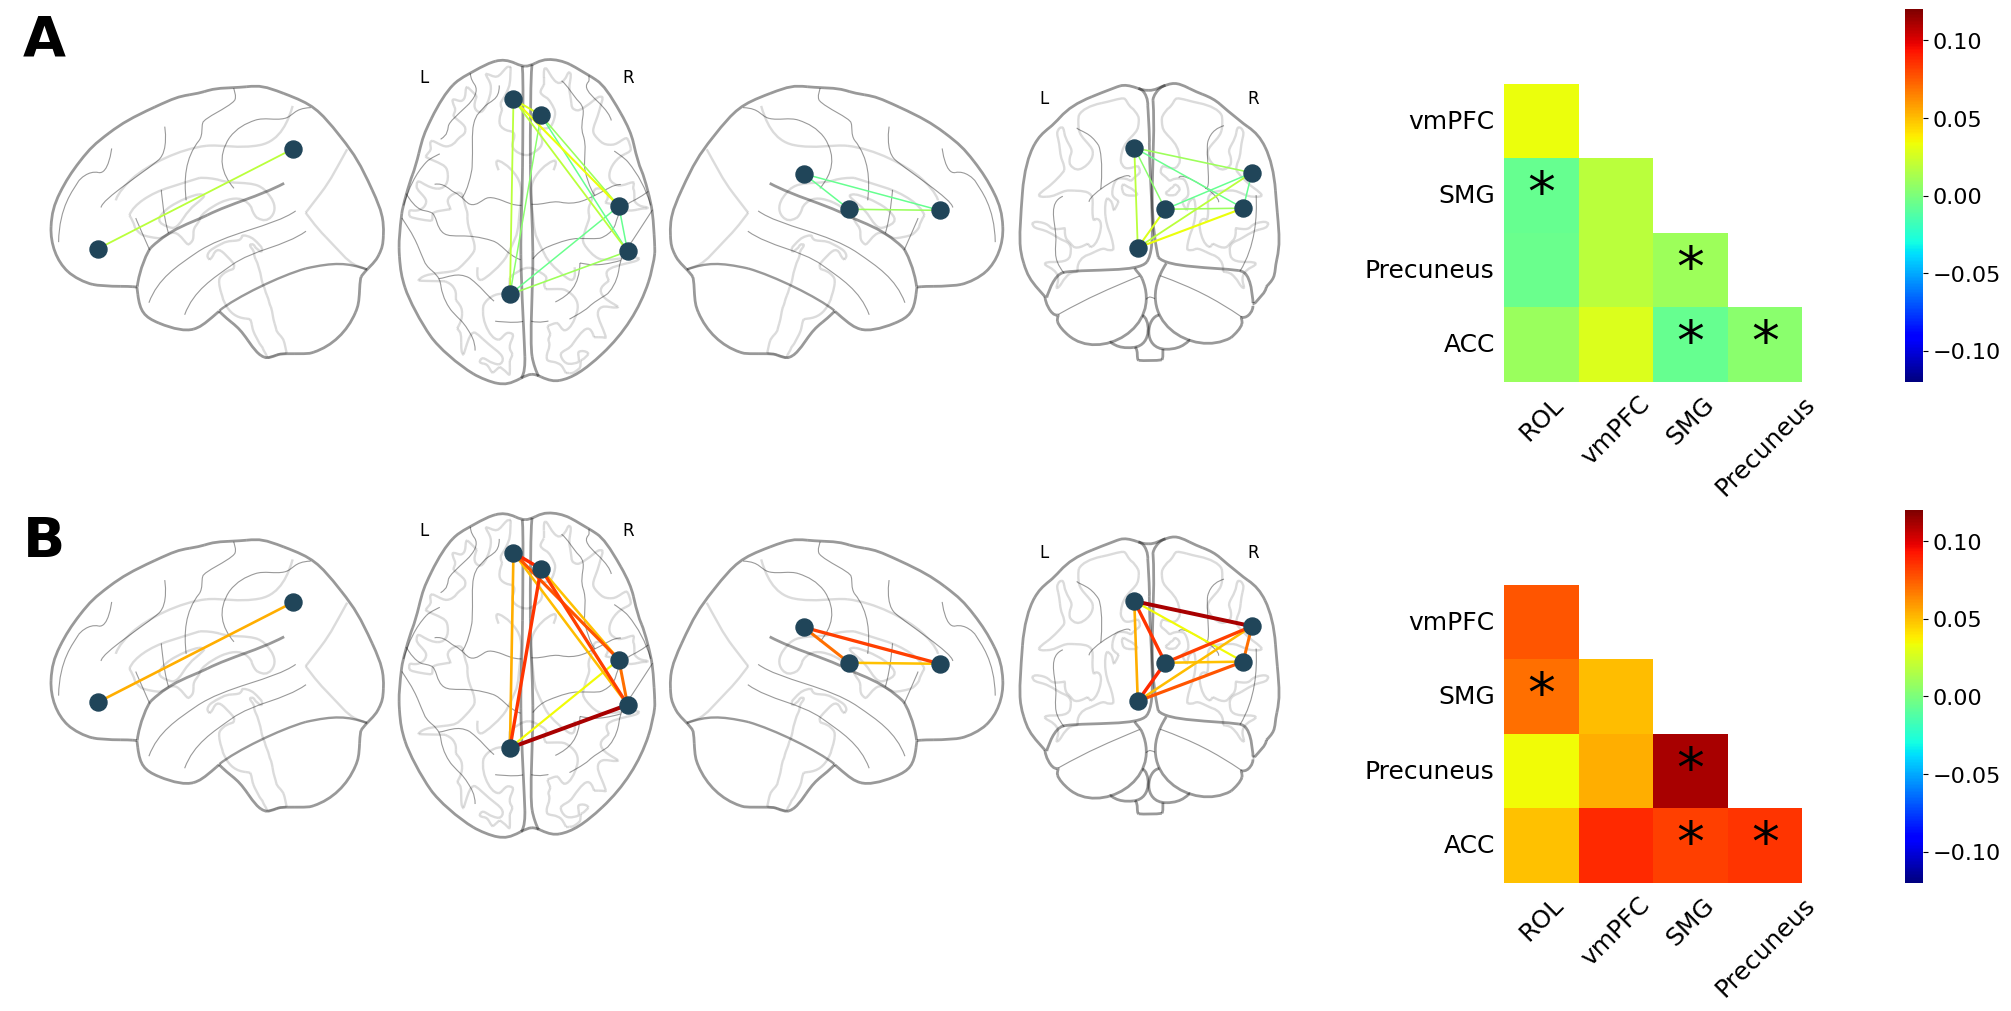

In [22]:
f,a = plt.subplots(ncols=2, nrows=2, figsize=(20,10), width_ratios=(0.7, 0.3), constrained_layout=True)

s2=sns.heatmap(avg_isfc_not_influenced, mask=np.triu(avg_isfc_not_influenced), cbar=True, vmin=-0.12, vmax=0.12, square=True, cmap='jet', xticklabels=['ROL','vmPFC','SMG','Precuneus',], yticklabels=['','vmPFC','SMG','Precuneus','ACC'], ax=a[1,1], fmt = '', annot = cell_labels, annot_kws = {'size': 40, 'color': 'black'})
s2.set_xticklabels(s2.get_xticklabels(), rotation=45, fontsize=18)
s2.set_yticklabels(s2.get_yticklabels(), rotation=0, fontsize=18)
s2.tick_params(left=False, bottom=False)
s2.collections[0].colorbar.ax.tick_params(labelsize=16)

s1=sns.heatmap(avg_isfc_influenced, mask=np.triu(avg_isfc_influenced), cbar=True, vmin=-0.12, vmax=0.12, square=True, cmap='jet', xticklabels=['ROL','vmPFC','SMG','Precuneus'], yticklabels=['','vmPFC','SMG','Precuneus','ACC'], ax=a[0,1], fmt = '', annot = cell_labels, annot_kws = {'size': 40, 'color': 'black'})
s1.set_xticklabels(s1.get_xticklabels(), rotation=45, fontsize=18)
s1.set_yticklabels(s1.get_yticklabels(), rotation=0, fontsize=18)
s1.tick_params(left=False, bottom=False)
s1.collections[0].colorbar.ax.tick_params(labelsize=16)

cmap = cm.Reds(np.linspace(0,1,20))
cmap = colors.ListedColormap(cmap[5:,:-1])
pc1 = plot_connectome(avg_isfc_influenced, atlascoords, node_color='#204559', node_size=150, display_mode='lzry', alpha=0.4, edge_vmax=0.12, edge_vmin=-0.12, edge_cmap='jet', colorbar=False, axes=a[0,0])
pc1.title(text='A', color='black', bgcolor='white', size=40, fontweight='bold')
pc2=plot_connectome(avg_isfc_not_influenced, atlascoords, display_mode='lzry', node_color='#204559', node_size=150, alpha=0.4, edge_vmax=0.12, edge_vmin=-0.12, edge_cmap='jet', colorbar=False, axes=a[1,0])
pc2.title(text='B', color='black', bgcolor='white', size=40, fontweight='bold')

f.savefig('D:/fmri_sugar/results/important/ISFC.png', dpi=300)

# <center><b> Post-hoc test for certain regions: Continuous relationship between ISC and influence? </b></center>

# We first save the pairwise ISC matrices for all ROIs

In [23]:
data = []
for sub in sub_list:
    sub_data = pd.read_csv(os.path.join(data_dir, f'{sub}_AAL.csv'))
    data.append(sub_data.values)
data = np.array(data)

In [24]:
n_subs, n_ts, n_nodes = data.shape

In [25]:
# Calculate the pairwise ISC matrix for each ROI
brain_similarity = []
for node in range(len(labels)):
    thisMatrix = Adjacency(1 - pairwise_distances(data[:, :, node], metric='correlation'), matrix_type='similarity')
    thisMatrix.data[np.isnan(thisMatrix.data)] = 0
    brain_similarity.append(thisMatrix)
brain_similarity = Adjacency(brain_similarity)

In [26]:
precuneus_pairwise_similarity = [brain_similarity[x] for x in range(len(labels)) if labels[x]=='Precuneus_L'][0]
precuneus_similarity = []
for i in range(n_subs):
    precuneus_similarity.append(np.median(np.delete(precuneus_pairwise_similarity.squareform()[i,:], i)))
r_precuneus, p_precuneus = pearsonr(precuneus_similarity, delta_sugarfree)

In [27]:
vmPFC_pairwise_similarity = [brain_similarity[x] for x in range(len(labels)) if labels[x]=='Frontal_Med_Orb_L'][0]
vmPFC_similarity = []
for i in range(n_subs):
    vmPFC_similarity.append(np.median(np.delete(vmPFC_pairwise_similarity.squareform()[i,:], i)))
r_vmPFC, p_vmPFC = pearsonr(vmPFC_similarity, delta_sugarfree)

In [28]:
preACC_pairwise_similarity = [brain_similarity[x] for x in range(len(labels)) if labels[x]=='ACC_pre_R'][0]
preACC_similarity = []
for i in range(n_subs):
    preACC_similarity.append(np.median(np.delete(preACC_pairwise_similarity.squareform()[i,:], i)))
r_preACC, p_preACC = pearsonr(preACC_similarity, delta_sugarfree)

In [29]:
SMG_pairwise_similarity = [brain_similarity[x] for x in range(len(labels)) if labels[x]=='SupraMarginal_R'][0]
SMG_similarity = []
for i in range(n_subs):
    SMG_similarity.append(np.median(np.delete(SMG_pairwise_similarity.squareform()[i,:], i)))
r_SMG, p_SMG = pearsonr(SMG_similarity, delta_sugarfree)

In [30]:
ROL_pairwise_similarity = [brain_similarity[x] for x in range(len(labels)) if labels[x]=='Rolandic_Oper_R'][0]
ROL_similarity = []
for i in range(n_subs):
    ROL_similarity.append(np.median(np.delete(ROL_pairwise_similarity.squareform()[i,:], i)))
r_ROL, p_ROL = pearsonr(ROL_similarity, delta_sugarfree)

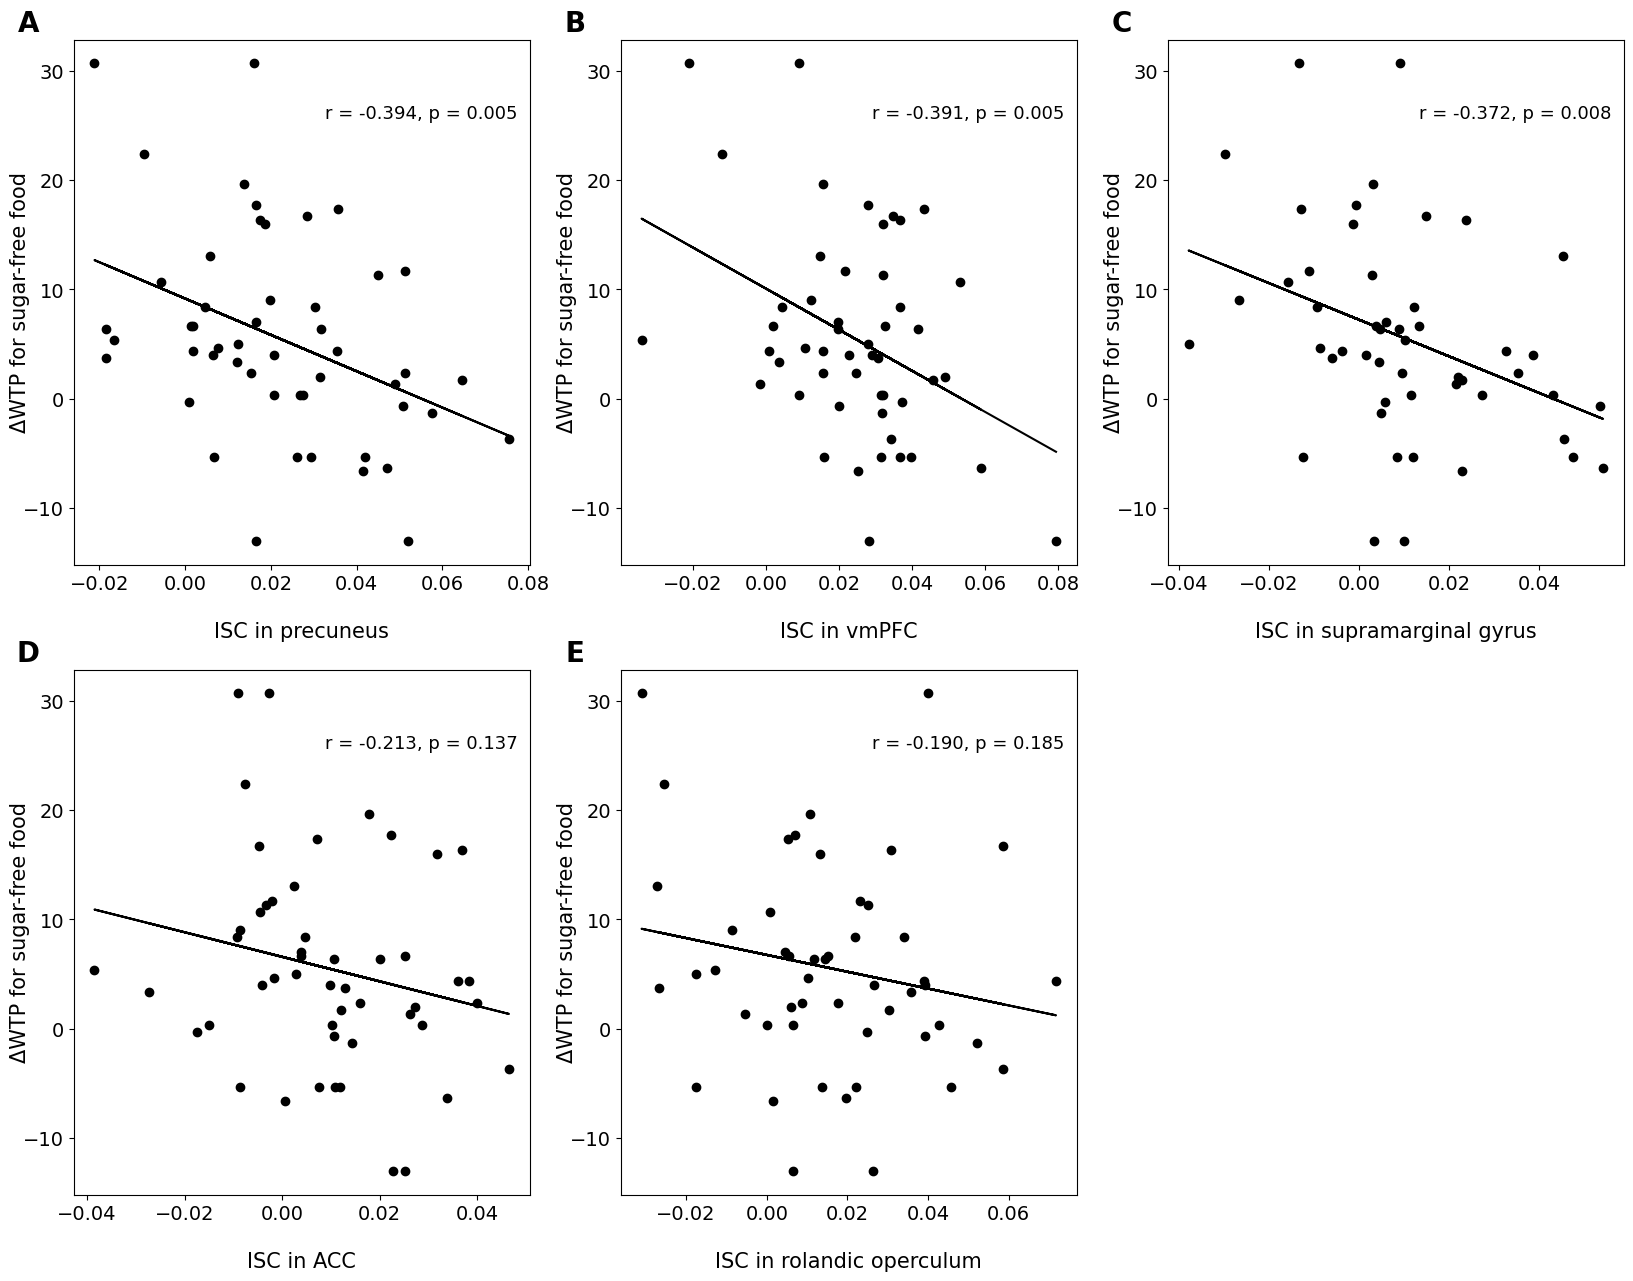

In [31]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20,15))

axes[0,0].scatter(precuneus_similarity, delta_sugarfree, color='k')
axes[0,0].tick_params(labelsize=14)
axes[0,0].set_xlabel('ISC in precuneus', size=15, labelpad = 20)
axes[0,0].set_ylabel('ΔWTP for sugar-free food', size=15, labelpad=-5)
m, b = np.polyfit(precuneus_similarity, delta_sugarfree, 1)
axes[0,0].plot(precuneus_similarity, m*np.array(precuneus_similarity)+b, color='k')
axes[0,0].annotate('r = {0:.3f}, p = {1:.3f}'.format(r_precuneus, p_precuneus), xy = (0.55, 0.85), xycoords = 'axes fraction', size=13)
axes[0,0].set_title('A', fontsize=20, fontweight='bold', x=-0.1)

axes[0,1].scatter(vmPFC_similarity, delta_sugarfree, color='k')
axes[0,1].tick_params(labelsize=14)
axes[0,1].set_xlabel('ISC in vmPFC', size=15, labelpad = 20)
axes[0,1].set_ylabel('ΔWTP for sugar-free food', size=15, labelpad=-5)
m, b = np.polyfit(vmPFC_similarity, delta_sugarfree, 1)
axes[0,1].plot(vmPFC_similarity, m*np.array(vmPFC_similarity)+b, color='k')
axes[0,1].annotate('r = {0:.3f}, p = {1:.3f}'.format(r_vmPFC, p_vmPFC), xy = (0.55, 0.85), xycoords = 'axes fraction', size=13)
axes[0,1].set_title('B', fontsize=20, fontweight='bold', x=-0.1)

axes[1,0].scatter(preACC_similarity, delta_sugarfree, color='k')
axes[1,0].tick_params(labelsize=14)
axes[1,0].set_xlabel('ISC in ACC', size=15, labelpad = 20)
axes[1,0].set_ylabel('ΔWTP for sugar-free food', size=15, labelpad=-5)
m, b = np.polyfit(preACC_similarity, delta_sugarfree, 1)
axes[1,0].plot(preACC_similarity, m*np.array(preACC_similarity)+b, color='k')
axes[1,0].annotate('r = {0:.3f}, p = {1:.3f}'.format(r_preACC, p_preACC), xy = (0.55, 0.85), xycoords = 'axes fraction', size=13)
axes[1,0].set_title('D', fontsize=20, fontweight='bold', x=-0.1)

axes[0,2].scatter(SMG_similarity, delta_sugarfree, color='k')
axes[0,2].tick_params(labelsize=14)
axes[0,2].set_xlabel('ISC in supramarginal gyrus', size=15, labelpad = 20)
axes[0,2].set_ylabel('ΔWTP for sugar-free food', size=15, labelpad=-5)
m, b = np.polyfit(SMG_similarity, delta_sugarfree, 1)
axes[0,2].plot(SMG_similarity, m*np.array(SMG_similarity)+b, color='k')
axes[0,2].annotate('r = {0:.3f}, p = {1:.3f}'.format(r_SMG, p_SMG), xy = (0.55, 0.85), xycoords = 'axes fraction', size=13)
axes[0,2].set_title('C', fontsize=20, fontweight='bold', x=-0.1)

axes[1,1].scatter(ROL_similarity, delta_sugarfree, color='k')
axes[1,1].tick_params(labelsize=14)
axes[1,1].set_xlabel('ISC in rolandic operculum', size=15, labelpad = 20)
axes[1,1].set_ylabel('ΔWTP for sugar-free food', size=15, labelpad=-5)
m, b = np.polyfit(ROL_similarity, delta_sugarfree, 1)
axes[1,1].plot(ROL_similarity, m*np.array(ROL_similarity)+b, color='k')
axes[1,1].annotate('r = {0:.3f}, p = {1:.3f}'.format(r_ROL, p_ROL), xy = (0.55, 0.85), xycoords = 'axes fraction', size=13)
axes[1,1].set_title('E', fontsize=20, fontweight='bold', x=-0.1)

axes[1,2].set_visible(False)

fig.savefig('D:/fmri_sugar/results/important/spectrum_posthoc.png', dpi=600)